In [1]:
import pandas as pd

# Загружаем данные

In [2]:
#user coordinates
df_user = pd.read_csv('user_coordinates.csv', index_col = 'user_id')
try:
    df_user = df_user.applymap(lambda x: float(x.replace(',','.'))) #small formatting to make sure that loc data are floats
except AttributeError:
    pass

df_user.head(10)

,loc_lat,loc_lon
user_id,,
1,55.737564,37.345186
2,56.234564,37.234590
3,55.234578,36.295745


In [3]:
#restaurant areas
df_rest = pd.read_csv('place_zone_coordinates.csv',delimiter = ';')

try:
    df_rest[['loc_lat','loc_lon']] = df_rest[['loc_lat','loc_lon']].applymap(lambda x: float(x.replace(',','.'))).values.tolist()
except AttributeError:
    pass

df_rest.head(10)

,place_id,loc_lat,loc_lon,point_number
0,1,55.747022,37.787073,0
1,1,55.751713,37.784328,1
2,1,55.753878,37.777638,2
3,1,55.751031,37.779351,3
4,2,55.803885,37.458311,0
5,2,55.808677,37.464054,1
6,2,55.809763,37.461314,2
7,2,55.810840,37.458654,3


In [22]:
%store df_user
%store df_rest

Stored 'df_user' (DataFrame)
Stored 'df_rest' (DataFrame)


In [2]:
%load df_user

ValueError: 'df_user' was not found in history, as a file, url, nor in the user namespace.

# Логика решения

# Решение с помощью метода пересекающего луча (метод 1)

In [4]:
#define class Point and RestArea(Polygon)

In [5]:
#some prep work

import sys
# _huge is used to act as infinity if we divide by 0
_huge = sys.float_info.max
# _eps is used to make sure points are not on the same line as vertexes
_eps = 0.00001


In [6]:
class Point:
   
    def __init__(self, x, y):
        """
        Хранит координаты точки (вершины полигона или пользователя Сервиса) 
        
        """
        self.x = x
        self.y = y


In [7]:
class Polygon:
    
    def __init__(self, df):
        """
        Хранит список координат полигона, который обслуживается рестораном
        """
        list = df[['loc_lat','loc_lon']].values.tolist()
        self.points = [Point(float(x),float(y)) for x,y in list]
        
   
    def edges(self):
        ''' Метод возвращает список кортежей из координат пары точек сегмента, образующих полигон '''
        edge_list = []
        
        for i,p in enumerate(self.points):
            p1 = p
            p2 = self.points[(i+1) % len(self.points)] #важно чтобы полигон был закрытый поэтому добавляем в конец еще раз вершину 0
            edge_list.append((p1,p2))

        return edge_list
    
    def contains(self, Point):

        # Значение переменной изначально ставим на False, чтобы в случае четного пересечения граней полигона ее значение осталось тоже False
        #False = точка находится вне полигона
        inside = False

        for edge in self.edges():
            # Для каждой грани определим верх и них, точка А всегда должна быть внизу для корректной работы алгоритма
            A, B = edge[0], edge[1]
            if A.y > B.y:
                A, B = B, A

            # Если горизонтальный луч пересекает вершину, то мы добавляем маленькое значение для координаты точки, чтобы наши дальнейшие тесты не учитывали это пересечение
            if Point.y == A.y or Point.y == B.y:
                Point.y += _eps

            # проверяем, что если луч проходит выше или ниже сегмента, либо находится справа, тогда пересечения нет, переходим к след итерации
            if (Point.y > B.y or Point.y < A.y or Point.x > max(A.x, B.x)):             
                continue

            # точка находится левее самой левого конца сегмента (при том что она "между" А и B по горизонтали) => есть пересечение
            if Point.x < min(A.x, B.x): 
                inside = not inside #фиксируем пересечение
                continue

            #здесь проверяем находится ли точка справа или слева от сегмента на основе угла наклона по отношению к точке А (которая нижняя)
            try:
                m_edge = (B.y - A.y) / (B.x - A.x)
            except ZeroDivisionError: #вариант когда сегмент вертикален
                m_edge = _huge

            try:
                m_Point = (Point.y - A.y) / (Point.x - A.x)
            except ZeroDivisionError: #вариант когда точка над нижней границей сегмента
                m_Point = -_huge

            if m_Point >= m_edge: #если угол наклона меньше, то точка лежит левее, те луч пересекает сегмент или случай когда сегмент вертикален и точка в нем
                inside = not inside
                continue
            
        return inside

In [8]:
#Алгоритм

In [9]:
def RayCastingMethod(df_rest,df_user):
    df_output = pd.DataFrame()
    for i,j in df_user.iterrows():
        U = Point(j[0],j[1])
    #    U = Point(55.752, 37.782) #можно проверить с данными входящими данными для пользователя, что алгоритм корректно работает
        rest_count = 0
        for m in df_rest['place_id'].unique():
            P = Polygon(df_rest[df_rest['place_id'] ==m])                
            if P.contains(U):
                rest_count = +1
        df_output.loc[i,'id'] = int(i)
        df_output.loc[i,'number_of_places_available'] = rest_count   
    return df_output

# Результаты метода 1

In [10]:
df_output = RayCastingMethod(df_rest,df_user)
df_output.astype(int).set_index('id')

,number_of_places_available
id,
1,0
2,0
3,0


# Решение с помощью библиотеки Mathplotlib (метод 2)

In [11]:
from matplotlib import path

In [12]:
def MtplMethod(df_rest,df_user):
    df = pd.DataFrame()
    for i in df_rest['place_id'].unique():    
        restaurant_area = df_rest[df_rest['place_id']==i][['loc_lat','loc_lon']].values.tolist()
        p = path.Path(restaurant_area)
        df = pd.concat([df,pd.DataFrame(p.contains_points(df_user))],axis = 1)
    return df


# Результаты метода 2

In [13]:
df = MtplMethod(df_rest,df_user)
df  = df.sum(axis = 1).to_frame().rename(columns = {0:'number_of_places_available'})
df = df.reindex(df.index.rename('id'))
df

,number_of_places_available
id,
0,0
1,0
2,0


# Сравнение скорости выполнения алгоритмов

In [14]:
print('Ray casting method:')
%timeit df_output = RayCastingMethod(df_rest,df_user)
print('Using mathplotlib:')
%timeit df_output = MtplMethod(df_rest,df_user)




Ray casting method:
8.28 ms ± 810 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Using mathplotlib:
2.31 ms ± 54.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Проверка

In [15]:
#checking
import matplotlib.pyplot as plt

In [16]:
#рестораны

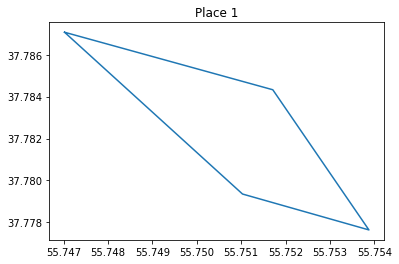

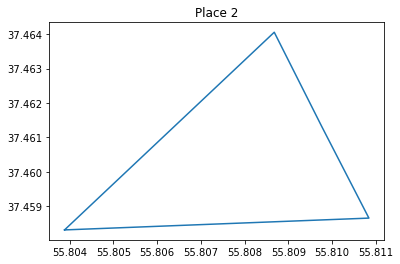

In [17]:
for i in df_rest['place_id'].unique():
    df_rest_help = df_rest[df_rest['place_id']==i]
    plt.title('Place '+str(df_rest_help.iloc[0,0]))
    coord = df_rest_help[['loc_lat','loc_lon']]
    coord = coord.append(coord[:1]) #repeat the first point to create a 'closed loop'
    plt.plot(coord['loc_lat'],coord['loc_lon'])
    plt.show()
   

In [18]:
# рестораны и пользователи

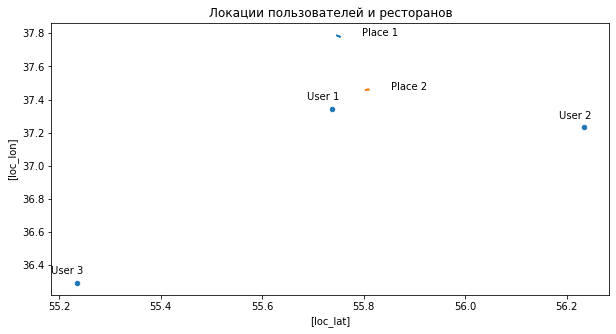

In [19]:
try:
    df_rest[['loc_lat','loc_lon']] = df_rest[['loc_lat','loc_lon']].applymap(lambda x:float(x.replace(',','.')))
except AttributeError:
    pass

fig, ax = plt.subplots(figsize = (10,5))
plt.title('Локации пользователей и ресторанов')
for place_id in df_rest['place_id'].unique():
    coord = df_rest[df_rest['place_id']==place_id][['loc_lat','loc_lon']]
    coord = coord.append(coord[:1]) #repeat the first point to create a 'closed loop'
    ax.plot(coord['loc_lat'],coord['loc_lon'])
df_user.plot(kind = 'scatter',x = ['loc_lat'],y = ['loc_lon'],ax = ax)
#plt.scatter(x = 55.752, y = 37.782)

for i,j in df_user.iterrows():
    ax.annotate('User '+str(i),(j[0]-0.05,j[1]+0.05))
    
for i in df_rest['place_id'].unique():
    df_rest_help = df_rest[df_rest['place_id']==i]
    x = df_rest_help.iloc[0][1]
    y = df_rest_help.iloc[0][2]
    id = int(df_rest_help.iloc[0][0])
    ax.annotate('Place '+str(id),(x+0.05,y))
        
plt.show()

# Анализ частных случаев

In [20]:
cases = [(0.5,0),(1,0),(1.5,0),(1.25,0.5),(1,1),(0.8,1),(0,1),(0.25,0.5),(0,0.5),(1,2),(2,0.5),(0,-1)]

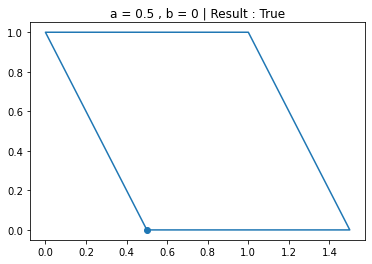

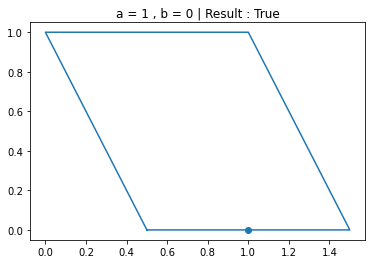

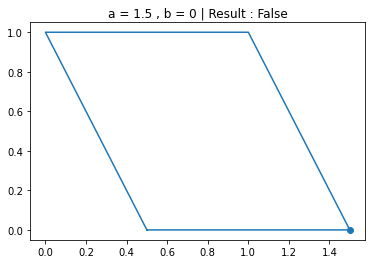

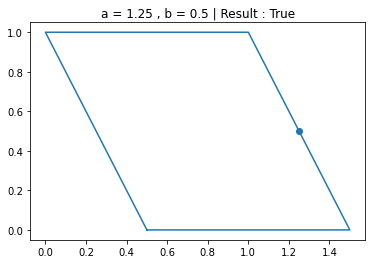

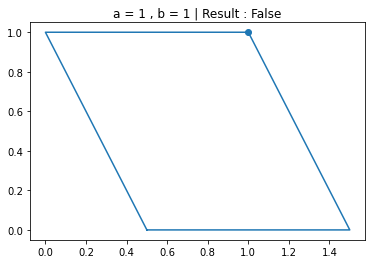

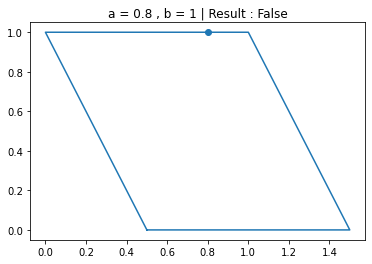

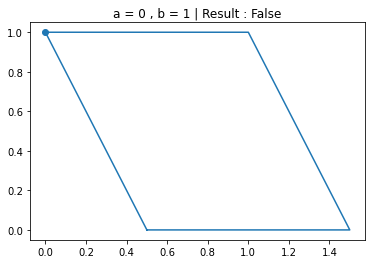

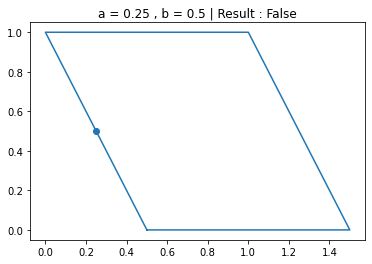

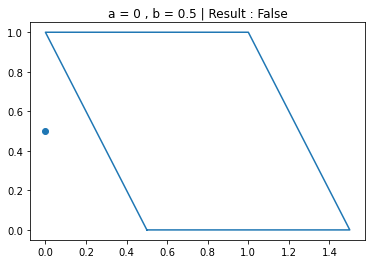

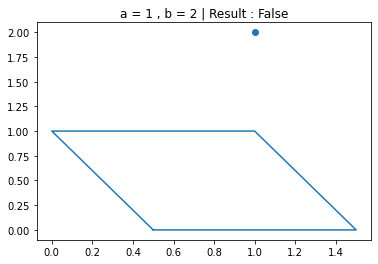

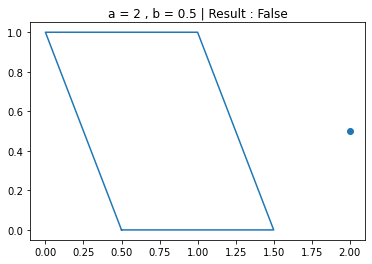

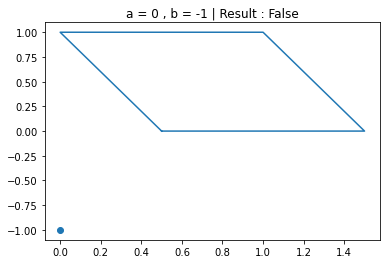

In [21]:
result = []
for a,b in cases:
    df = pd.DataFrame({'loc_lat':[0.5,1.5,1,0],'loc_lon':[0,0,1,1]})
    P = Polygon(df)
    U = Point(a,b)
    df = df.append(df[:1])
    plt.plot(df['loc_lat'],df['loc_lon'])
    plt.scatter(a,b)
    plt.title('a = '+str(a)+' , b = '+str(b)+' | Result : '+str(P.contains(U)))
    plt.show()